In [35]:
#Installing the imbalanced learn module for access to a variety of over-sampling methods

#!pip install imbalanced-learn
#!pip install numpy==1.21
#!pip install lxml

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
df = pd.read_csv('Data/clean_gss.csv')
df.head()
print(df.shape)

(689, 16)


In [38]:
# Getting rid of redundant columns from initial dataframe

gss= df[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','is_si', 'MOREWEEKS', 'Age Group', 'INTCNTCT']]
gss.head()

,SATJOB,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,is_si,MOREWEEKS,Age Group,INTCNTCT
0,4.0,1.0,5.0,5.0,4.0,3.0,0,1,4,5.0
1,4.0,1.0,3.0,4.0,3.0,4.0,1,1,3,4.0
2,4.0,1.0,4.0,3.0,4.0,1.0,0,4,2,5.0
3,3.0,1.0,4.0,3.0,4.0,5.0,1,1,3,5.0
4,3.0,1.0,3.0,3.0,2.0,5.0,1,1,2,6.0


<AxesSubplot:>

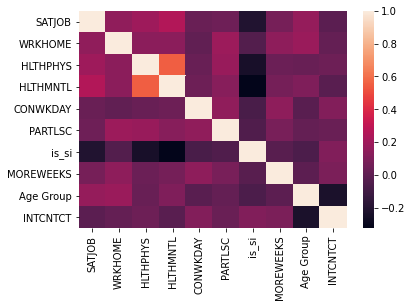

In [39]:
# Checking for multicollinearity- looks good

corr = gss.corr()
sns.heatmap(corr)

In [40]:
# Starting to split data to prepare for modeling

X= gss[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','MOREWEEKS', 'Age Group','INTCNTCT']]
y= gss['is_si']

In [41]:
from imblearn.over_sampling import SMOTEN
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

# Resampling only the training data
os= SMOTEN(random_state= 42)
os_X, os_y= os.fit_resample(X_train, y_train)

In [42]:
# Verifying we now have 50/50 isolated to non-isolated for training data

os_y.value_counts()

1    366
0    366
Name: is_si, dtype: int64

In [43]:
# SATJOB, HLTHPHYS, PARTLSC, MARITAL_2, MARITAL_5 all have p-value above 0.05 lacking statistical significance

import statsmodels.api as sm

sm_logit = sm.Logit(os_y, os_X)
result = sm_logit.fit()
print(result.summary())

#save results for later
summary_df5 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

Optimization terminated successfully.
         Current function value: 0.571169
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  732
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            8
Date:                Tue, 18 Apr 2023   Pseudo R-squ.:                  0.1760
Time:                        12:36:58   Log-Likelihood:                -418.10
converged:                       True   LL-Null:                       -507.38
Covariance Type:            nonrobust   LLR p-value:                 2.050e-34
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SATJOB         0.1066      0.107      0.992      0.321      -0.104       0.317
WRKHOME       -0.2708      0.

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

sk_logit = LogisticRegression()
sk_logit.fit(os_X, os_y)
y_pred = sk_logit.predict(X_test)
print('Accuracy on test set:{:.2f}'.format(sk_logit.score(X_test, y_test)))

Accuracy on test set:0.65


In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.69      0.75       155
           1       0.37      0.54      0.44        52

    accuracy                           0.65       207
   macro avg       0.59      0.61      0.59       207
weighted avg       0.70      0.65      0.67       207



In [46]:
for age_group in gss['Age Group'].unique():
    age = gss.loc[gss['Age Group']== age_group]
    
    # Starting to split data to prepare for modeling
    
    #'Marital_2.0','Marital_3.0', 'Marital_4.0', 'Marital_5.0'
    X= age[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','MOREWEEKS','INTCNTCT']]
    y= age['is_si']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.30, random_state= 42)

    # Resampling only the training data
    os= SMOTEN(random_state= 42)
    os_X, os_y= os.fit_resample(X_train, y_train)

    sm_logit = sm.Logit(os_y, os_X)
    result = sm_logit.fit()
    print("Age Group:{:.2f}".format(age_group))
    print(result.summary())

    sk_logit = LogisticRegression()
    sk_logit.fit(os_X, os_y)
    y_pred = sk_logit.predict(X_test)
    print('Accuracy on test set:{:.2f}'.format(sk_logit.score(X_test, y_test)))
    print(classification_report(y_test, y_pred))
#Saving summary data to a dataframe for plots
    if age_group==1.0:
        summary_df1 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if age_group==2.0:
        summary_df2 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if age_group==3.0:
        summary_df3 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if age_group==4.0:
        summary_df4 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]


    

Optimization terminated successfully.
         Current function value: 0.402130
         Iterations 7
Age Group:4.00
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  104
Model:                          Logit   Df Residuals:                       96
Method:                           MLE   Df Model:                            7
Date:                Tue, 18 Apr 2023   Pseudo R-squ.:                  0.4198
Time:                        12:36:58   Log-Likelihood:                -41.822
converged:                       True   LL-Null:                       -72.087
Covariance Type:            nonrobust   LLR p-value:                 1.182e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SATJOB         0.8517      0.380      2.241      0.025       0.107       1.597
WRKHOME       

In [47]:
#Create a new list to hold data that will be used for plotting
summary_plot = []

#Add a new column in each summary dataframe that indicates the Age group of the dataframe
summary_df1['Age Group'] = 1
summary_df2['Age Group'] = 2
summary_df3['Age Group'] = 3
summary_df4['Age Group'] = 4
summary_df5['Age Group'] = 5

for table in [summary_df1,summary_df2,summary_df3,summary_df4, summary_df5]:
    #Track the index
    index= 0
    for row in table['P>|z|']:
        
        if row <= .05:
            summary_plot.append(table.iloc[index])
        index+=1
       

In [48]:
summary_df = pd.DataFrame()
for each_df in summary_plot:
    summary_df = pd.concat([summary_df, each_df], axis=1 )
summary_df = summary_df.transpose()
summary_df['Age Group'] = summary_df['Age Group'].astype('int32')

In [49]:
summary_df.rename(index={'HLTHPHYS': 'Physical Health',
                         'CONWKDAY':'# of Weekday Interactions', 
                         'HLTHMNTL':'Mental Health',
                         'MOREWEEKS':'Extra Hours Worked',
                         'PARTLSC':'Participation in groups',
                         'SATJOB':'Job Satisfaction',
                         'WRKHOME':'Work from Home',
                        'INTCNTCT':'Electronic Communication'},inplace=True)
list(summary_df.index)


['Physical Health',
 'Extra Hours Worked',
 'Electronic Communication',
 'Work from Home',
 'Electronic Communication',
 'Job Satisfaction',
 'Work from Home',
 'Mental Health',
 'Participation in groups',
 'Electronic Communication',
 'Job Satisfaction',
 'Mental Health',
 '# of Weekday Interactions',
 'Electronic Communication',
 'Work from Home',
 'Mental Health',
 '# of Weekday Interactions',
 'Electronic Communication']

In [50]:
summary_df

,coef,std err,z,P>|z|,[0.025,0.975],Age Group
Physical Health,-1.0367,0.284,-3.655,0.000,-1.593,-0.481,1
Extra Hours Worked,-0.4620,0.226,-2.042,0.041,-0.905,-0.019,1
Electronic Communication,0.7679,0.189,4.062,0.000,0.397,1.138,1
Work from Home,-0.3371,0.104,-3.256,0.001,-0.540,-0.134,2
Electronic Communication,0.5733,0.118,4.838,0.000,0.341,0.806,2
Job Satisfaction,1.6865,0.294,5.728,0.000,1.109,2.264,3
Work from Home,-0.5233,0.156,-3.362,0.001,-0.828,-0.218,3
Mental Health,-1.3495,0.292,-4.621,0.000,-1.922,-0.777,3
Participation in groups,-0.4531,0.155,-2.919,0.004,-0.757,-0.149,3
Electronic Communication,0.4194,0.139,3.009,0.003,0.146,0.693,3


In [51]:
# plotting some radar plots?
# ne
# much courtesy of https://www.python-graph-gallery.com/392-use-faceting-for-radar-chart
# Libraries
from math import pi
from matplotlib import colormaps

# categories are the var names
# only doing one group. Group A
# values is every value under A plus a repeat of the first (so it closes)
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider( row, title, color, df):
    # number of variable
    categories=list(df.index)
    N = len(categories)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the spider plot
    ax = plt.subplot(3,2,row, polar=True, )
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=15)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0,1,2,3,4,5], ["0","1","2",'3','4','5'], color="black", size=10)
    plt.ylim(0,5)
    # Ind1
    #values=df.loc[row].drop('group').values.flatten().tolist()
    # values=df.iloc[:,row-1].tolist()
    values = abs(df['coef']).tolist()
    values += values[:1]
    print(f'{values} {angles}')
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    # Add a title
    plt.title(title, size=18, color=color, y=1.0,x=0.01)
    
# ------- PART 2: Apply the function to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1500/my_dpi, 1300/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = colormaps["Set2"]
 
# # Loop to plot
# for row in range(0, len(df.index)):
#     make_spider( row=row, title='group '+df['group'][row], color=my_palette(row))
    
for row in summary_df['Age Group'].unique():
    title = ''
    if row == 1:
        title = '18-29 \n Accuracy: 64%\n\n'
        #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        #break
    if row == 2:
        title = '30-44 \n Accuracy: 72%\n\n'
        #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        #break
    if row == 3:
        title = '45-59 \n Accuracy: 60%\n\n'
        make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        break
    if row == 4:
        title = '60+ \n Accuracy: 80%\n\n'
        #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        #break
    if row == 5:
        title = 'All\nAccuracy: 72%\n\n'
        #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        #break
    #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])

ImportError: cannot import name 'colormaps' from 'matplotlib' (C:\Users\dnhor\anaconda3\lib\site-packages\matplotlib\__init__.py)

In [ ]:
plot_data = pd.DataFrame(summary_plot)
plot_data['Variable']= plot_data.index

In [ ]:
clean_plot_data = pd.DataFrame(pd.crosstab(plot_data['Age Group'],plot_data['Variable'],values=plot_data['coef'],aggfunc=sum))
clean_plot_data

In [ ]:
#plt.figure(figsize=(10,10))
ax = clean_plot_data.transpose().plot.bar(figsize=(8,7),rot=0,cmap='tab20b')

plt.title('Variables Affecting Social Isolation', fontsize=18)
plt.ylabel('Coeficients',fontsize=15)
plt.xlabel('',fontsize=15)
ax.tick_params(axis='y',labelsize=10)
ax.tick_params(axis='x', labelsize=12,rotation=45)
ax.set_xticklabels(['# of Weekday Interactions', 'Mental Health', 'Physical Health','moreweeks', 'Participation in groups','Job Satisfaction','Work from Home'])
plt.setp(ax.xaxis.get_majorticklabels(), ha="right" )
ax.legend(labels=['18-29', '30-44','45-59','60+'])

In [ ]:
#plt.figure(figsize=(10,10))
ax = clean_plot_data.transpose().plot.barh(figsize=(8,7),rot=0,cmap='tab20b')

plt.title('Variables Affecting Social Isolation', fontsize=18)
plt.xlabel('Coeficients',fontsize=15)
plt.ylabel('',fontsize=15)
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y', labelsize=10)
ax.set_yticklabels(['# of Weekday Interactions', 'Mental Health', 'Physical Health','Job Overtime','Participation in Groups','Job Satisfaction','Work From Home'])
plt.setp(ax.yaxis.get_majorticklabels(), ha="right" )
ax.legend(labels=['18-29', '30-44','45-59','60+'])

In [ ]:
# regular logit for all age groups
# https://napsterinblue.github.io/notes/machine_learning/regression/interaction_terms/

x = gss[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','EDUC', 'MOREWEEKS']]
y = gss['is_si']

In [ ]:
# rebalancing

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state= 42)

# Resampling only the training data
os = SMOTEN(random_state= 42)
x_train, y_train= os.fit_resample(x_train, y_train)

In [ ]:
# statsmodels logit

sm_logit = sm.Logit(y_train, x_train)
result = sm_logit.fit()
print(result.summary())

In [ ]:
# sklearn logit

sk_logit = LogisticRegression()
sk_logit.fit(x_train, y_train)
y_pred = sk_logit.predict(x_test)
print('Accuracy on test set:{:.2f}'.format(sk_logit.score(x_test, y_test)))

In [ ]:
# let's work on some interactive terms
# how many columns can we expect after adding interactive terms?

print(x.shape)
p = len(x.columns)
expected_columns = (p * (p-1)) / 2 + p + 1
print(f'expected columns: {expected_columns}')

In [ ]:
# let's import
from sklearn.preprocessing import PolynomialFeatures

# and let's do the thing

interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# we wanna keep out feature names
from itertools import count
import re

x_to_feature = dict(zip(('x{}'.format(i) for i in count()), x.columns))
feature_keys = list(x_to_feature.keys())[::-1]

features = []

# these two lines were originally below line 30
x_inter = interaction.fit_transform(x)
x_inter_const = sm.add_constant(x_inter)

for feature in interaction.get_feature_names_out():
    for key in feature_keys:
        feature_name = x_to_feature[key]
        feature = re.sub(key, feature_name, feature)
    feature = re.sub(' ', '_', feature)
    features.append(feature)

# these next two lines actually do the column name swapping? is this the right spot?
x_inter = pd.DataFrame(x_inter, columns=features)
x_inter_const = sm.add_constant(x_inter)


x_inter_const.shape
# is this 37 as well? solido

In [ ]:
print(x_inter.shape)
sns.heatmap(x_inter.corr(), cmap="PiYG")

In [ ]:
# let's remove multi collinearity
from collinearity import SelectNonCollinear # https://github.com/gianlucamalato/collinearity
from sklearn.feature_selection import f_regression, SelectFdr, chi2
import numpy as np
def rem_collinear_features(correlation_threshold: float, scoring, x_df: pd.DataFrame, y_df: pd.DataFrame):
    selector = SelectNonCollinear(correlation_threshold, scoring=scoring)

    selector.fit(x_df.to_numpy(), y_df.to_numpy())
    mask = selector.get_support() # TODO: read doc on get_support()
    
    return pd.DataFrame(x_df.loc[:,mask],columns = np.array(x_df.columns)[mask]) 

In [ ]:
x_inter = rem_collinear_features(0.88, chi2, x_inter, y)

In [ ]:
# now let us do this again but with interactive terms
# resplit
# rebalance
# re-logit
x_train, x_test, y_train, y_test = train_test_split(x_inter, y, test_size= 0.3, random_state= 42)

# Resampling only the training data
os = SMOTEN(random_state = 42)
x_train, y_train= os.fit_resample(x_train, y_train)

# sklearn logit
sk_logit = LogisticRegression()
sk_logit.fit(x_train, y_train)
y_pred = sk_logit.predict(x_test)
print('sklearn Accuracy on test set:{:.2f}'.format(sk_logit.score(x_test, y_test)))

# statsmodel logit
sm_logit = sm.Logit(y_train, x_train)
result = sm_logit.fit()
print(f'statsmodels: \n{result.summary()}')

# Polynomial interactive terms is not the way